# Understanding the Influential Factors of Energy Consumption



In this report, we focus on analyzing the factors that influence energy consumption in a specific residential house. The dataset at our disposal contains detailed information on gas and electricity consumption for this house over a given period. Additionally, we have access to weather data, including temperature, wind speed, rainfall, and other relevant meteorological variables, which may influence energy usage.

## Data preparation

We have data on the energy consumption of a family house between September 2022 and April 2023. Their electricity and gas consumption is recorded every fifteen minutes. In addition to that, we have also recorded the low-cost hours and high-cost hours. During weekends and nighttime on weekdays (between 20:45 and 6:15), energy costs are reduced, corresponding to the low-cost hours.
To better analyze the energy consumption patterns of the family, we are also interested in the weather data corresponding to the area where the house is located. We will primarily focus on the external temperature.

In [3]:
# To avoid module import error
import sys
import os
import warnings

 
# Hide warnings

sys.path.append('../')  # Add the parent directory to the system path


from tools.openweather import openweather_data
openweather_data=openweather_data.copy()

from tools.home_messages_db  import *
# db_url = 'sqlite:///myhome.db'
db_url = f'sqlite:///{os.path.join(os.path.dirname(os.getcwd()), "myhome.db")}'


# energy tables import and transformation

db=home_messages_db(db_url)
#consumption = db.getData_pd(tablename="Consumption")
consumption = db.getData_pd(tablename="Consumption").drop(["consumption_id","source_id"],axis=1)
consumption["time"]=pd.to_datetime(consumption["time"].astype(int), unit='s', origin='unix')
#consumption["time"]=pd.to_datetime(consumption["time"])
##import the weather dataset 
from tools.openweather import openweather_data
openweather_data=openweather_data.copy()
# we separate electricity and gas consumption
elec_consumption=consumption.loc[consumption.type=="electricity"]
gas_consumption=consumption.loc[consumption.type=="gas"]

## Energy consumption analysis

During the recorded period, the average electricity consumption is 0.104 kWh. It can reach a maximum of 1.43 kWh. As for gas consumption, it is lower, ranging from 0 to 0.95 kWh, with an average of 0.035 kWh.

In [17]:
elec_consumption.dtypes
elec_consumption.head()
elec_consumption.describe()

,time,value
count,106668,106668.000000
mean,2022-09-19 09:46:34.566318080,0.104784
min,2022-03-18 14:30:00,0.001000
25%,2022-06-15 20:45:00,0.037000
50%,2022-10-05 22:00:00,0.060000
75%,2022-12-09 13:45:00,0.111000
max,2023-04-04 21:30:00,1.432000
std,NaN,0.125320


In [5]:
gas_consumption.dtypes
gas_consumption.head()
gas_consumption.describe()

,time,value
count,100125,100125.000000
mean,2022-09-30 00:53:28.062921216,0.034693
min,2022-03-18 14:30:00,0.000000
25%,2022-07-12 15:30:00,0.000000
50%,2022-10-11 08:00:00,0.010000
75%,2022-12-13 21:30:00,0.053000
max,2023-04-04 22:30:00,0.953000
std,NaN,0.059023


In order to visualize the variation in energy consumption more effectively, we have decided to aggregate it on a daily and monthly basis.

In [15]:
import pandas as pd

def aggregate(data, name_time_column,groupby):
    # Aggregate the 'value' column by day,month or year and by type of time
    day_month_or_year=groupby[0].upper()
    aggregated_data = data.groupby([pd.Grouper(key=name_time_column, freq=day_month_or_year),'type_time']).agg({'value': 'sum','type':'first'}).reset_index()
    return aggregated_data

elec_by_day=aggregate(elec_consumption, "time","day")
gas_by_day=aggregate(gas_consumption, "time","day")
elec_by_month=aggregate(elec_consumption, "time","month")
gas_by_month=aggregate(gas_consumption, "time","month")

In [34]:
summary_month = elec_by_month.describe().loc[:,'value'].to_frame().rename( {"value":"Electric"}, axis=1).join(gas_by_month.describe().loc[:,'value'].to_frame().rename( {"value":"Gas"}, axis=1)).round(2)

In [32]:
import seaborn as sb 
import matplotlib.pyplot as plt
sb.set_theme(style="whitegrid", palette="pastel")

We can see a first insight into the summary statistics that electricity usage is somewhat higher than gas usage. Furthermore, there don't seem to be any big outliers

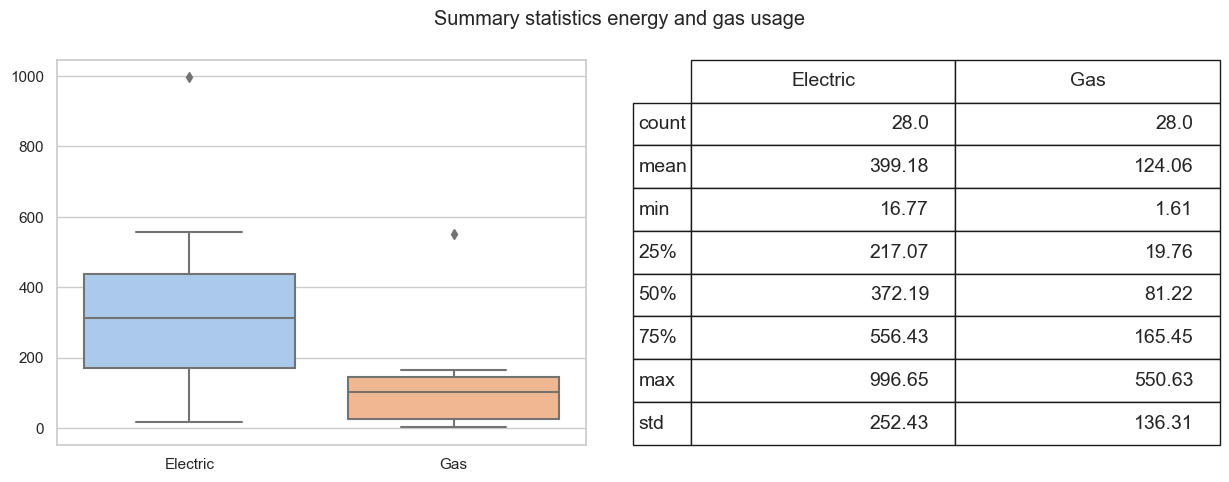

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Summary statistics energy and gas usage')

ax1 = sb.boxplot(summary_month, ax = axs[0])

ax2 = axs[1]
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = summary_month.values, rowLabels = summary_month.index, bbox=bbox, colLabels=summary_month.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

We will now look into the progression of energy and gas usage troughout the year. On the plot, we observe a significant decrease in energy consumption during the month of August, indicating an off-peak period. As this period coincides with the summer season, it is reasonable to assume that the occupants of the house were away on vacation.

To confirm this hypothesis, we can analyze the activity within the house during this period by examining device messages.

In contrast, there is a substantial increase in gas consumption during the winter months. This suggests that gas is primarily used for heating purposes in the house, as colder temperatures lead to higher demand for heating to maintain a comfortable indoor environment.

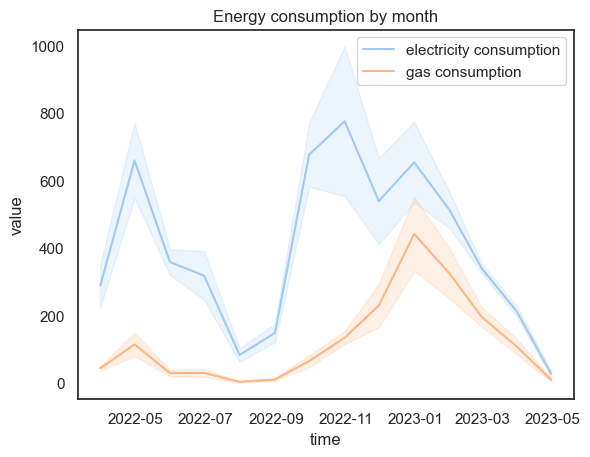

In [41]:
sb.set_style("white") 

sb.lineplot(x='time', y='value', data=elec_by_month,label='electricity consumption')
sb.lineplot(x='time', y='value', data=gas_by_month,label='gas consumption')

plt.title('Energy consumption by month')
plt.legend()
plt.show()

In the previous graph, we can observe that our curves are bounded. This corresponds to the consumption during high vs. low-cost hours.
We then compared the consumption during low-cost and high-cost hours. The two consumptions show a similar pattern.
However, it is noteworthy that the consumption is higher during low-cost hours, which is a positive trend. This could be attributed to the conscious efforts of the occupants to practice responsible energy consumption or the convenience of their schedule aligning with the low-cost hours, allowing them to be at home predominantly during those periods.

For the next part of our analysis, we will focus on gas consumption.

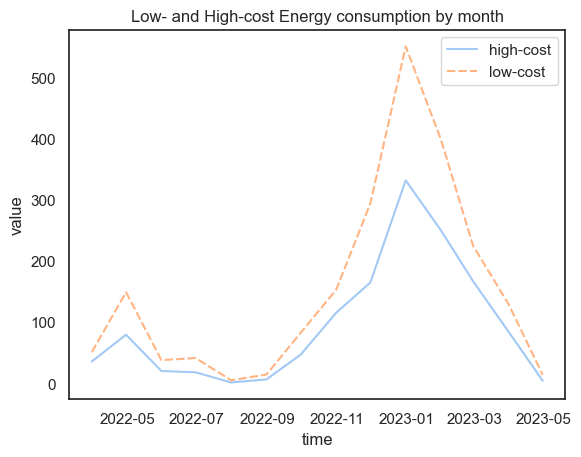

In [42]:
sb.lineplot(x='time', y='value', data=gas_by_month,hue="type_time", style="type_time")
plt.title('Low- and High-cost Energy consumption by month')
plt.legend()


## Weather analysis

The data are from the beginning of this year (2023). We'll analyze rapidly the whole variables and then focus on the temperature. We have their values each hours

We plotted a correlation plot so we can see the correlation between the different weather related variables. The temperature and the soil temperature are highly correlated, which sounds logical. However the correlation between the others variables are not really significative, which can be surprising. 
We don't have a large dataset and have to take it into consideration in our further analysis.

<Axes: >

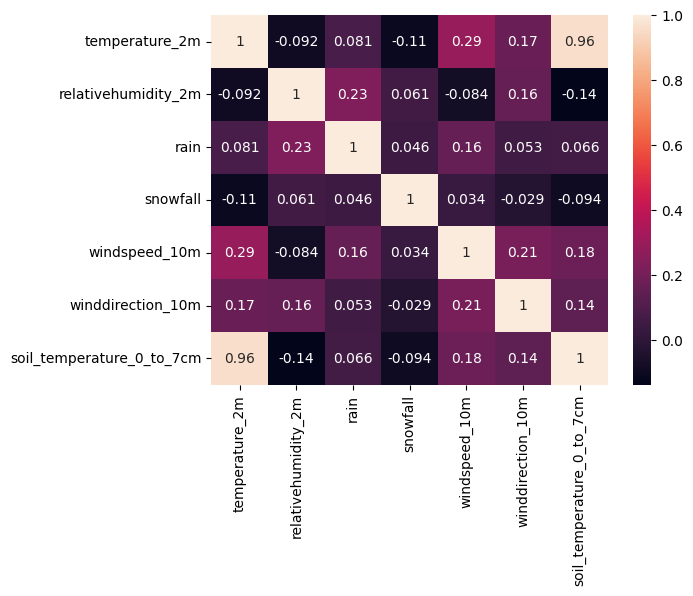

In [51]:
openweather_data.describe()
corr_matrix = openweather_data.drop("time",axis=1).corr()
sb.heatmap(corr_matrix, annot=True)

We can observe varying temperatures, but we can distinguish two phases: one with low mean temperatures dropping below 2°C, and another with higher mean temperatures reaching over 14°C. We can presume that this difference corresponds to the change in seasons.

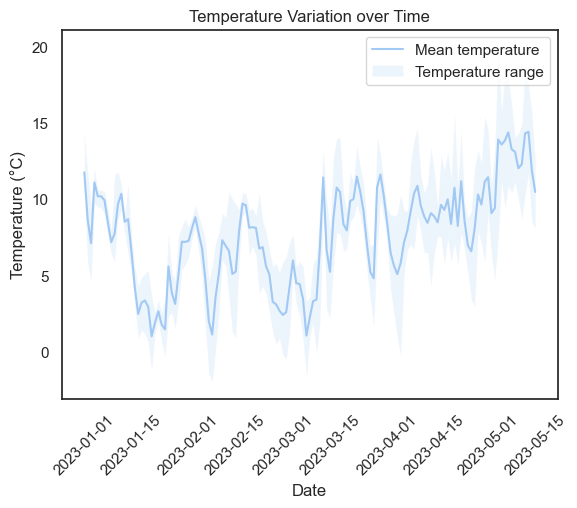

In [43]:
# change the format of the time to UTC
openweather_data['time'] = pd.to_datetime(openweather_data['time'], unit='s')
openweather_data

# aggregate our temperature by day takin into consideration the mean and the range (min and max)
daily_temperatures = openweather_data.groupby(pd.Grouper(key='time', freq='D')).agg(
    temperature_mean=('temperature_2m', 'mean'),
    temperature_min=('temperature_2m', 'min'),
    temperature_max=('temperature_2m', 'max')
).reset_index()

#plot
plt.plot(daily_temperatures['time'], daily_temperatures['temperature_mean'], label='Mean temperature')
plt.fill_between(daily_temperatures['time'], daily_temperatures['temperature_min'], daily_temperatures['temperature_max'],
                 alpha=0.2, label='Temperature range')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

By distinguishing the two ongoing seasons (winter then summer), we can clearly see the two distinct patterns.

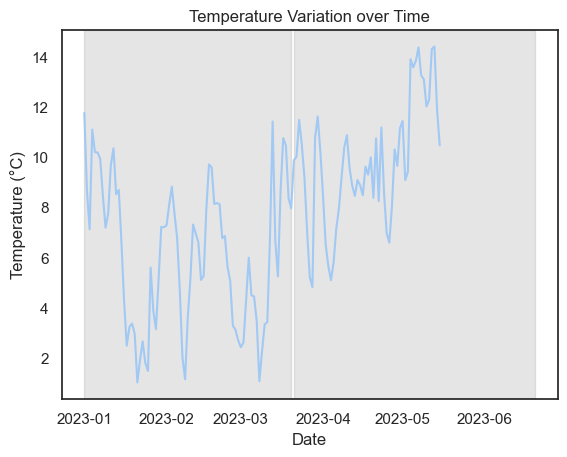

In [45]:

# we will keep only the daily mean temperature for the analysis
openweather_data=openweather_data.groupby(pd.Grouper(key="time", freq='D')).mean().reset_index()
graph = sb.lineplot(x='time', y='temperature_2m', data=openweather_data)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation over Time')
# Define the seasons
seasons = [('2023-01-01', '2023-03-20'),  # Winter
           ('2023-03-21', '2023-06-20')]  # Summer

# Plot vertical bars for each season
for season in seasons:
    plt.axvspan(season[0], season[1], alpha=0.2, color='gray')

plt.show()


We can also look at the energy and gass consumption dependent on the weather. This results in the following plot. Firstly, because of the limeted weather usage we don't have a nice full year cycle. However, even this limeted data confirms our suspicion that lower temperature leads to more consumption and visa versa.

In [92]:
# First filter daily_temperature on elec_by month
mask = (elec_by_month["time"] >= min(daily_temperatures['time'])) & (elec_by_month["time"] <= max(daily_temperatures['time']))

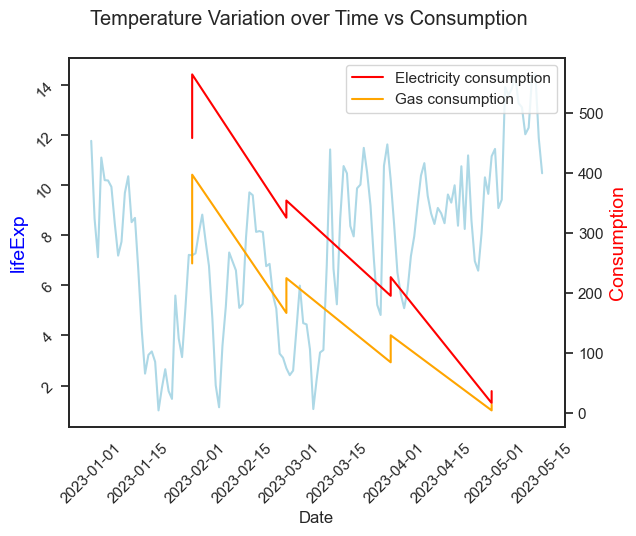

In [95]:
# Secondly make the plots
fig,axs = plt.subplots()
fig.suptitle('Temperature Variation over Time vs Consumption')

axs.plot(daily_temperatures['time'], daily_temperatures['temperature_mean'], color = "lightblue")
axs.set_xlabel('Date',fontsize = 12)
axs.set_ylabel("lifeExp",
              color="blue",
              fontsize=14)
axs.tick_params(labelrotation=45)

# Used to make the share x-axis
ax2=axs.twinx()

ax2.plot(elec_by_month.loc[mask, "time"],elec_by_month.loc[mask, "value"], label='Electricity consumption', color = "red")
ax2.plot(gas_by_month.loc[mask, "time"], gas_by_month.loc[mask, "value"], label='Gas consumption', color = "orange")
ax2.legend()
ax2.set_ylabel("Consumption",
              color="red",
              fontsize=14)

plt.show()

## Regression linear

After conducting the analysis, we will proceed with a linear regression to generalize the relationship between gas consumption and the other factors we have discussed, such as temperature and the type of time (low/high cost).

It is important to note that this analysis is relatively simple due to the limited size of our weather data. With a larger sample size, we may be able to develop a more complex model.

In [54]:
# regression 
from sklearn.linear_model import LinearRegression

openweather_data
consumption_and_weather=gas_by_day.merge(openweather_data, on='time', how='left').dropna()[["type_time","value","temperature_2m"]]
consumption_and_weather.head()

,type_time,value,temperature_2m
495,low-cost,7.408,11.758333
496,high-cost,14.128,8.654167
497,low-cost,12.920,8.654167
498,high-cost,21.420,7.120833
499,low-cost,12.480,7.120833


Afterwards, we performed our regression linear.Looking at the coefficients, we observed that as the temperature increases, the gas consumption decreases, and it also decreases during high-cost hours. These results align with our previous analysis. However, it is important to note that our model performs poorly, as indicated by this small R-squared value of 0.03.

In [55]:

from sklearn.model_selection import train_test_split, cross_val_score

encoded_data = pd.get_dummies(consumption_and_weather, columns=['type_time'])
X=encoded_data.drop("value",axis=1)
y=encoded_data["value"]

model = LinearRegression()


# Fit the model on the training set
model.fit(X, y)
r_squared=model.score(X, y)

coefficients = model.coef_
intercept = model.intercept_
coefficients_named = dict(zip(X.columns, coefficients))
coefficients_named["intercept"]=intercept
coefficients_named
print ("r_squared : {}, coefficients : {} ".format(r_squared,coefficients_named))

r_squared : 0.03772930294640353, coefficients : {'temperature_2m': -0.34371079499209334, 'type_time_high-cost': -0.3243545610268549, 'type_time_low-cost': 0.32435456102685484, 'intercept': 10.04647452164103} 


In conclusion, energy consumption varies over time and is influenced by several factors. We have attempted to capture these trends and understand their relationships. Our analysis has revealed that energy consumption is dependent on temperature and other factors such as the cost of energy. By focusing on gas consumption, which is associated with heating, we have developed a model that aligns with our initial analyses. However, it is important to note that the model can be further improved.

To enhance the model's performance, it would be beneficial to have a larger dataset, including more observations and variables. This would allow us to capture a wider range of information and reduce the variability of the model's predictions. Additionally, considering the distribution of consumption and temperature, employing techniques such as splines with knots corresponding to different seasons or utilizing time series models could lead to better results.

By incorporating these improvements, we can refine our understanding of energy consumption patterns and make more accurate predictions, which can ultimately aid in optimizing energy usage and informing decision-making processes related to energy management.